# NF2FF Offsets in Python

First test with implementing my NF2FF methods from MATLAB in Python. For this test, we do the simple horizontal offset with no interpolation, to make sure everything works well. For now, I am still using the sample data provided with the NF2FF code to create the figure.

In [139]:
## CLONING the NF2FF Script from MATLAB: https://www.mathworks.com/matlabcentral/fileexchange/23385-nf2ff

## import statements:
import numpy as np
from matplotlib.pyplot import *
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftshift
from numpy.fft import ifftshift
from scipy.interpolate import interp2d

from electric_field_errors import *
from NF2FF import *

import pandas
from matplotlib.colors import LogNorm

from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import RegularGridInterpolator

In [181]:
## Specified input parameters from MATLAB folks:
c=299792458.0 # Speed of light in vacuum [m/s]
broadcast_freq=94*10^9 # broadcast frequency in hertz
sdata=np.array(pandas.read_csv('sample_data.csv',header=None)).flatten()
sdata=np.array([complex(x.replace('i','j')) for x in sdata]).reshape((51,51,201))
sdata2=np.array(pandas.read_csv('s21_data2.csv',header=None)).flatten()
sdata2=np.array([complex(x.replace('i','j')) for x in sdata2]).reshape((51,51,201))
freq=np.loadtxt('sample_frequencies.csv',delimiter=',') #Hz
N=len(freq)
f_start=freq[1]
f_stop=freq[-1]
df=(f_stop-f_start)/(N-1)
dt=1.0/(N*df)
t=np.arange(N-1)*dt
x=c*t

# See equations (16-10a) and (16-10b) in Balanis
M=51#sdata.xpoints; # Amount of samples in the x direction (along table, left to right)
N=51#sdata.ypoints; # Amount of samples in the y direction (across table, front to back)
dx=1/1000#sdata.x_step/1000; # Sample spacing in the x direction [m]
dy=1/1000#sdata.y_step/1000; # Sample spacing in the y direction [m]
# See equations (16-10a) and (16-10b) in Balanis
a=dx*(M-1); # The length of the scanned area in the x direction [m]
b=dy*(N-1); # The length of the scanned area in the y direction [m]
x=np.linspace(-a/2,a/2,M)
y=np.linspace(-b/2,b/2,N)
z0=0.006;

# See equations (16-13a) and (16-13b) in Balanis
# Zero padding is used to increase the resolution of the plane wave spectral domain.
MI=4*M;#2^(ceil(log2(M))+1);
NI=4*N;#2^(ceil(log2(N))+1);
m=np.linspace(-MI/2,MI/2-1,MI);
n=np.linspace(-NI/2,NI/2-1,NI)
k_X_Rectangular=(2*np.pi*m)/(MI*dx);
k_Y_Rectangular=(2*np.pi*n)/(NI*dy);
[k_X_Rectangular_Grid,k_Y_Rectangular_Grid]=np.meshgrid(k_X_Rectangular,k_Y_Rectangular);
dtheta=0.05;
dphi=0.05;
theta_1d=np.arange(-np.pi/2+dtheta,np.pi/2-dtheta,dtheta);
phi_1d=np.arange(0+dphi,np.pi-dphi,dphi);
[theta,phi]=np.meshgrid(theta_1d,phi_1d);

In [182]:
# adding in offset gridding for one offset

# determining amount of offset based on Nyquist spacing
lambda_m=c/broadcast_freq
nyquist_sampling_m=lambda_m/2; # necessary grid spacing in m
pct_offset=0.1
offset=nyquist_sampling_m*pct_offset
x_offset=x+offset

# creating k-space grid with offset
m_offset_spaced=m+offset/dx # see explanation for this formula page 40 of lab notebook
k_X_Rectangular_Offset=2*np.pi*m_offset_spaced/(MI*dx)
k_Y_Rectangular_Offset=2*np.pi*n/(NI*dy)
[k_X_Rectangular_Offset_Grid,k_Y_Rectangular_Offset_Grid] = np.meshgrid(k_X_Rectangular_Offset,k_Y_Rectangular_Offset)

In [183]:
find=200
f=freq[find];print(f*1e-9)
lambda0=c/f;
k0=2*np.pi/lambda0;
NF_X_Complex=sdata[:,:,find]
NF_Y_Complex=sdata2[:,:,find]
NF_X_Magnitude = (np.abs(NF_X_Complex));
NF_Y_Magnitude = (np.abs(NF_Y_Complex));
from skimage.restoration import unwrap_phase
NF_X_Phase=unwrap_phase(np.angle(NF_X_Complex),wrap_around=True)
NF_Y_Phase=unwrap_phase(np.angle(NF_Y_Complex),wrap_around=True)

110.0


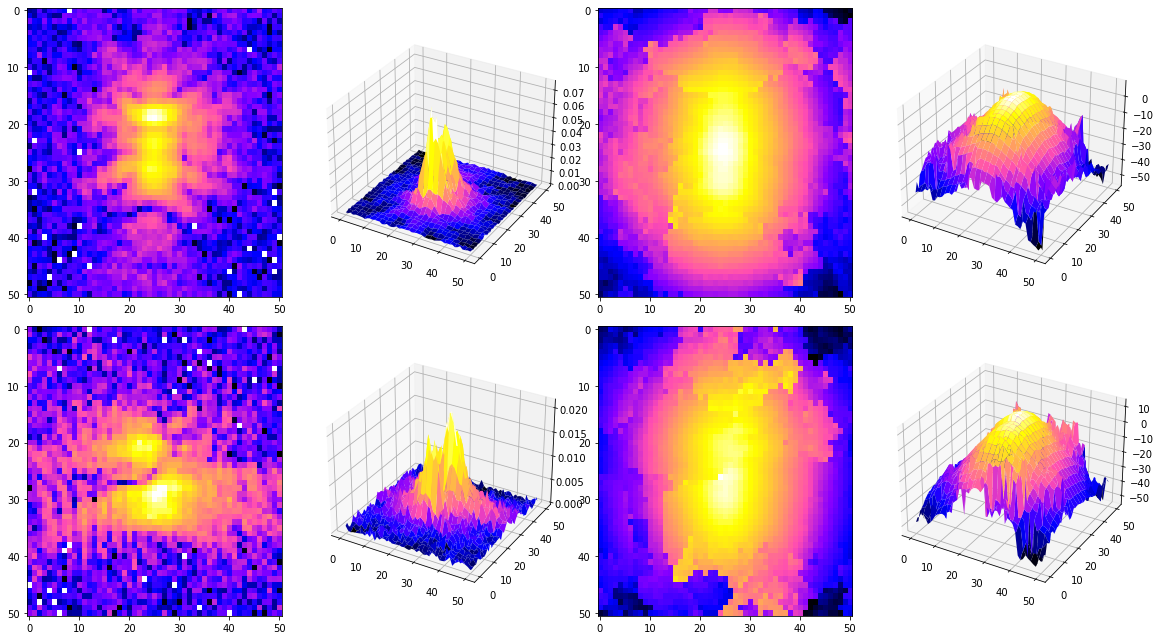

In [184]:
fig=figure(figsize=(16,9))
ax=fig.add_subplot(2, 4, 1)
ax.imshow(NF_X_Magnitude,aspect='auto',cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(2, 4, 2, projection='3d')
[X,Y]=np.meshgrid(np.arange(51),np.arange(51))
ax.plot_surface(X,Y,NF_X_Magnitude,cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(2, 4, 5)
ax.imshow(NF_Y_Magnitude,aspect='auto',cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(2, 4, 6, projection='3d')
ax.plot_surface(X,Y,NF_Y_Magnitude,cmap='gnuplot2',norm=LogNorm())
tight_layout()

ax=fig.add_subplot(2, 4, 3)
ax.imshow(NF_X_Phase,aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(2, 4, 4, projection='3d')
[X,Y]=np.meshgrid(np.arange(51),np.arange(51))
ax.plot_surface(X,Y,NF_X_Phase,cmap='gnuplot2')
ax=fig.add_subplot(2, 4, 7)
ax.imshow(NF_Y_Phase,aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(2, 4, 8, projection='3d')
ax.plot_surface(X,Y,NF_Y_Phase,cmap='gnuplot2')
tight_layout()

In [185]:
def NFtoFourier (NF_X,NF_Y,kx_grid,ky_grid,k0,plotFourier=False):
    grid_size = np.shape(kx_grid)
    MI = grid_size[0]
    NI = grid_size[1]
    
    kz_grid=np.emath.sqrt((k0**2.0)-(kx_grid**2.0)-(ky_grid**2.0));
    print(kz_grid)
    fx=ifftshift(ifft2(NF_X,[MI,NI],axes=[0,1]))
    fy=ifftshift(ifft2(NF_Y,[MI,NI],axes=[0,1]))
    fz=(-1.0*((fx*kx_grid)+(fy*ky_grid)))/kz_grid
    
    # this magnitude is not in dB, can be plotted in dB by taking log and multiplying by 20 or simply using lognorm plotting
    fx_magnitude=(np.abs(fx));
    fy_magnitude=(np.abs(fy));
    fz_magnitude=(np.abs(fz));
    
    if plotFourier == True:
        fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5.5))
        ax1.pcolormesh(kx_grid,ky_grid,fx_magnitude,cmap='gnuplot2',norm=LogNorm())
        ax2.pcolormesh(kx_grid,ky_grid,fy_magnitude,cmap='gnuplot2',norm=LogNorm())
        ax3.pcolormesh(kx_grid,ky_grid,fz_magnitude,cmap='gnuplot2',norm=LogNorm())
        ax1.set_aspect('equal')
        ax2.set_aspect('equal')
        ax3.set_aspect('equal')
        tight_layout()

    return [fx, fy, fz, fx_magnitude, fy_magnitude, fz_magnitude]

[[0.+3797.92094591j 0.+3772.48333224j 0.+3747.12619801j ...
  0.+3721.85118814j 0.+3747.12619801j 0.+3772.48333224j]
 [0.+3772.48333224j 0.+3746.87302596j 0.+3721.34138778j ...
  0.+3695.89004805j 0.+3721.34138778j 0.+3746.87302596j]
 [0.+3747.12619801j 0.+3721.34138778j 0.+3695.63336604j ...
  0.+3670.00374647j 0.+3695.63336604j 0.+3721.34138778j]
 ...
 [0.+3721.85118814j 0.+3695.89004805j 0.+3670.00374647j ...
  0.+3644.19387821j 0.+3670.00374647j 0.+3695.89004805j]
 [0.+3747.12619801j 0.+3721.34138778j 0.+3695.63336604j ...
  0.+3670.00374647j 0.+3695.63336604j 0.+3721.34138778j]
 [0.+3772.48333224j 0.+3746.87302596j 0.+3721.34138778j ...
  0.+3695.89004805j 0.+3721.34138778j 0.+3746.87302596j]]
[[0.+4.94829984e+08j 0.+4.94830014e+08j 0.+4.94830045e+08j ...
  0.+4.94836174e+08j 0.+4.94836205e+08j 0.+4.94836236e+08j]
 [0.+4.94829984e+08j 0.+4.94830014e+08j 0.+4.94830045e+08j ...
  0.+4.94836174e+08j 0.+4.94836205e+08j 0.+4.94836236e+08j]
 [0.+4.94829984e+08j 0.+4.94830014e+08j 0.+4.9

<ipython-input-185-ba8a72cfcecc>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(kx_grid,ky_grid,fx_magnitude,cmap='gnuplot2',norm=LogNorm())
<ipython-input-185-ba8a72cfcecc>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(kx_grid,ky_grid,fy_magnitude,cmap='gnuplot2',norm=LogNorm())
<ipython-input-185-ba8a72cfcecc>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since

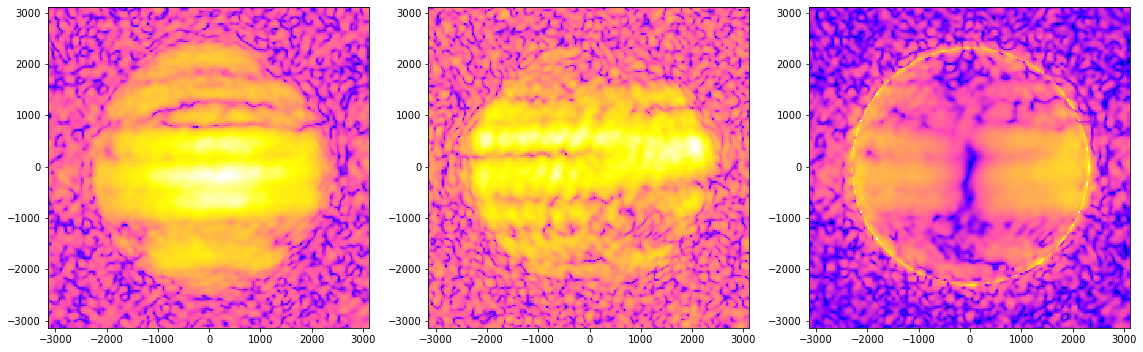

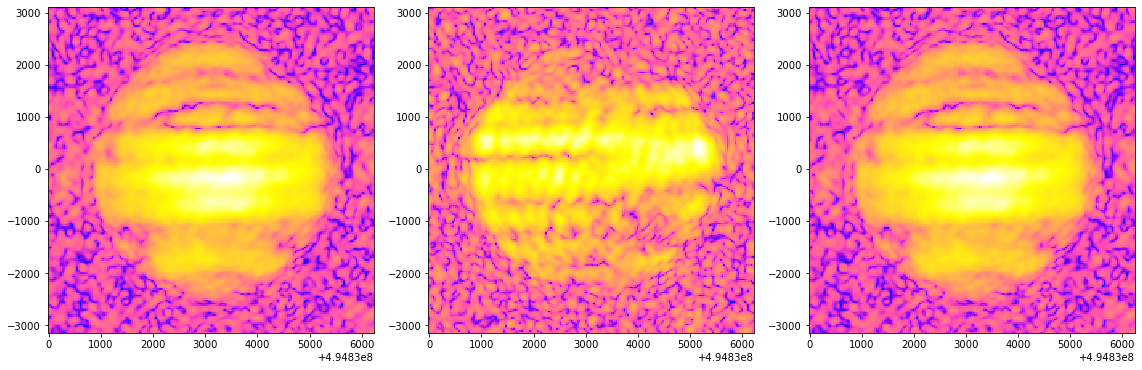

In [186]:
FourierSpace=NFtoFourier(NF_X_Complex,NF_Y_Complex,k_X_Rectangular_Grid,k_Y_Rectangular_Grid,k0,plotFourier=True)
FourierSpace_offset = NFtoFourier(NF_X_Complex,NF_Y_Complex,k_X_Rectangular_Offset_Grid,k_Y_Rectangular_Offset_Grid,k0,plotFourier=True)

In [187]:
# things I've tried: differnet interpolations methods, Will's method except for the offsets case as well--I get really big errors

def FouriertoFF(FourierSpace,theta,phi,k_x_vector,k_y_vector,k0,FFOutputs=False):
    
    f_x = FourierSpace[0]
    f_y = FourierSpace[1]
    f_z = FourierSpace[2]
    
    f_x_real = f_x.real
    f_x_imag = f_x.imag
    f_y_real = f_y.real
    f_y_imag = f_y.imag
    f_z_real = f_z.real
    f_z_imag = f_z.imag
    
    yy=(k0*np.sin(theta)*np.sin(phi))
    xx=(k0*np.sin(theta)*np.cos(phi))
    
    from scipy.interpolate import RectBivariateSpline
    from scipy.interpolate import RegularGridInterpolator
    
#     f_x_real_interp = RectBivariateSpline(k_x_vector,k_y_vector,f_x_real)
#     f_x_imag_interp = RectBivariateSpline(k_x_vector,k_y_vector,f_x_imag)
#     f_y_real_interp = RectBivariateSpline(k_x_vector,k_y_vector,f_y_real)
#     f_y_imag_interp = RectBivariateSpline(k_x_vector,k_y_vector,f_y_imag)
#     f_z_real_interp = RectBivariateSpline(k_x_vector,k_y_vector,f_z_real)
#     f_z_imag_interp = RectBivariateSpline(k_x_vector,k_y_vector,f_z_imag)
    
#     f_x_real_interp = RegularGridInterpolator((k_x_vector,k_y_vector),f_x_real)
#     f_x_imag_interp = RegularGridInterpolator((k_x_vector,k_y_vector),f_x_imag)
#     f_y_real_interp = RegularGridInterpolator((k_x_vector,k_y_vector),f_y_real)
#     f_y_imag_interp = RegularGridInterpolator((k_x_vector,k_y_vector),f_y_imag)
#     f_z_real_interp = RegularGridInterpolator((k_x_vector,k_y_vector),f_z_real)
#     f_z_imag_interp = RegularGridInterpolator((k_x_vector,k_y_vector),f_z_imag)
    
    f_x_real_interp = interp2d(k_x_vector,k_y_vector,f_x_real,kind='linear')
    f_x_imag_interp = interp2d(k_x_vector,k_y_vector,f_x_imag,kind='linear')
    f_y_real_interp = interp2d(k_x_vector,k_y_vector,f_y_real,kind='linear')
    f_y_imag_interp = interp2d(k_x_vector,k_y_vector,f_y_imag,kind='linear')
    f_z_real_interp = interp2d(k_x_vector,k_y_vector,f_z_real,kind='linear')
    f_z_imag_interp = interp2d(k_x_vector,k_y_vector,f_z_imag,kind='linear')
    
    f_X_Spherical_real=f_x_real_interp(xx,yy)
    f_X_Spherical_imag=f_x_imag_interp(xx,yy)
    f_X_Spherical=f_X_Spherical_real + 1.0j*f_X_Spherical_imag
    f_Y_Spherical_real=f_y_real_interp(xx,yy)
    f_Y_Spherical_imag=f_y_imag_interp(xx,yy)
    f_Y_Spherical=f_Y_Spherical_real + 1.0j*f_Y_Spherical_imag
    f_Z_Spherical_real=f_z_real_interp(xx,yy)
    f_Z_Spherical_imag=f_z_imag_interp(xx,yy)
    f_Z_Spherical = f_Z_Spherical_real + 1.0j*f_Z_Spherical_imag
        
    fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
    ax1.imshow(20*np.log10(np.abs(f_X_Spherical)),aspect='auto',norm=LogNorm(),cmap='gnuplot2')
    ax2.imshow(20*np.log10(np.abs(f_Y_Spherical)),aspect='auto',norm=LogNorm(),cmap='gnuplot2')
    
    
    r=10000;
    C=1.0j*(k0*np.exp(-1.0j*k0*r))/(2*np.pi*r)
    Etheta=C*(f_X_Spherical*np.cos(phi)+f_Y_Spherical*np.sin(phi));
    Ephi=C*np.cos(theta)*(-f_X_Spherical*np.sin(phi)+f_Y_Spherical*np.cos(phi));
    
    if FFOutputs==True:
        fig=figure(figsize=(9,9))
        ax=fig.add_subplot(2,2,1)
        ax.pcolormesh(theta,phi,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
        ax.set_aspect('equal')
        ax=fig.add_subplot(2,2,2)
        ax.pcolormesh(theta,phi,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')
        ax.set_aspect('equal')
        ax=fig.add_subplot(2,2,3,projection='3d')
        ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Etheta))-np.nanmax(20.0*np.log10(np.abs(Etheta.T.conj()))),cmap='gnuplot2')
        ax.view_init(30,-37.5)
        ax=fig.add_subplot(2,2,4,projection='3d')
        ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Ephi))-np.nanmax(20.0*np.log10(np.abs(Ephi.T.conj()))),cmap='gnuplot2')
        ax.view_init(30,-37.5)
    
    return [Etheta,Ephi]

In [197]:
def FouriertoFF2(f_x,f_y,f_z,theta,phi,k_x,k_y,k0,FFOutputs=False):
    
    xx = k0*np.sin(theta)*np.cos(phi)
    yy = k0*np.sin(theta)*np.sin(phi)
    points = [[xx[i],yy[i]] for i in range(len(xx))]
    
    print(k_x)
    
    f_x_interp = RectBivariateSpline(k_y,k_x,np.abs(f_x))
    f_y_interp = RectBivariateSpline(k_y,k_x,np.abs(f_y))
    f_z_interp = RectBivariateSpline(k_y,k_x,np.abs(f_z))

#     f_x_interp = RegularGridInterpolator((k_x,k_y),np.abs(f_x))
#     f_y_interp = RegularGridInterpolator((k_x,k_y),np.abs(f_y))
#     f_z_interp = RegularGridInterpolator((k_x,k_y),np.abs(f_z))
    
#     f_X_Spherical = f_x_interp(points,method='linear')
#     f_Y_Spherical = f_y_interp(points,method='linear')
#     f_Z_Spherical = f_z_interp(points,method='linear')

    f_X_Spherical = f_x_interp.ev(yy,xx)
    f_Y_Spherical = f_y_interp.ev(yy,xx)
    f_Z_Spherical = f_z_interp.ev(yy,xx)
    
    print(f_X_Spherical)
    
    fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,5))
    ax1.imshow((np.abs(f_X_Spherical)),aspect='equal',norm=LogNorm(),cmap='gnuplot2')
    ax2.imshow((np.abs(f_Y_Spherical)),aspect='equal',norm=LogNorm(),cmap='gnuplot2')
    
    r=10000;
    C=1.0j*(k0*np.exp(-1.0j*k0*r))/(2*np.pi*r)
    Etheta=C*(f_X_Spherical*np.cos(phi)+f_Y_Spherical*np.sin(phi));
    Ephi=C*np.cos(theta)*(-f_X_Spherical*np.sin(phi)+f_Y_Spherical*np.cos(phi));
    
    if FFOutputs==True:
        fig=figure(figsize=(9,9))
        ax=fig.add_subplot(2,2,1)
        ax.pcolormesh(theta,phi,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
        ax.set_aspect('equal')
        ax=fig.add_subplot(2,2,2)
        ax.pcolormesh(theta,phi,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')
        ax.set_aspect('equal')
        ax=fig.add_subplot(2,2,3,projection='3d')
        ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Etheta))-np.nanmax(20.0*np.log10(np.abs(Etheta.T.conj()))),cmap='gnuplot2')
        ax.view_init(30,-37.5)
        ax=fig.add_subplot(2,2,4,projection='3d')
        ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Ephi))-np.nanmax(20.0*np.log10(np.abs(Ephi.T.conj()))),cmap='gnuplot2')
        ax.view_init(30,-37.5)
        
    return [Etheta,Ephi]
    

[-3141.59265359 -3110.79272561 -3079.99279764 -3049.19286966
 -3018.39294168 -2987.59301371 -2956.79308573 -2925.99315776
 -2895.19322978 -2864.3933018  -2833.59337383 -2802.79344585
 -2771.99351787 -2741.1935899  -2710.39366192 -2679.59373394
 -2648.79380597 -2617.99387799 -2587.19395002 -2556.39402204
 -2525.59409406 -2494.79416609 -2463.99423811 -2433.19431013
 -2402.39438216 -2371.59445418 -2340.7945262  -2309.99459823
 -2279.19467025 -2248.39474228 -2217.5948143  -2186.79488632
 -2155.99495835 -2125.19503037 -2094.39510239 -2063.59517442
 -2032.79524644 -2001.99531846 -1971.19539049 -1940.39546251
 -1909.59553453 -1878.79560656 -1847.99567858 -1817.19575061
 -1786.39582263 -1755.59589465 -1724.79596668 -1693.9960387
 -1663.19611072 -1632.39618275 -1601.59625477 -1570.79632679
 -1539.99639882 -1509.19647084 -1478.39654287 -1447.59661489
 -1416.79668691 -1385.99675894 -1355.19683096 -1324.39690298
 -1293.59697501 -1262.79704703 -1231.99711905 -1201.19719108
 -1170.3972631  -1139.597

<ipython-input-197-60057291b8d9>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(theta,phi,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
<ipython-input-197-60057291b8d9>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(theta,phi,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')


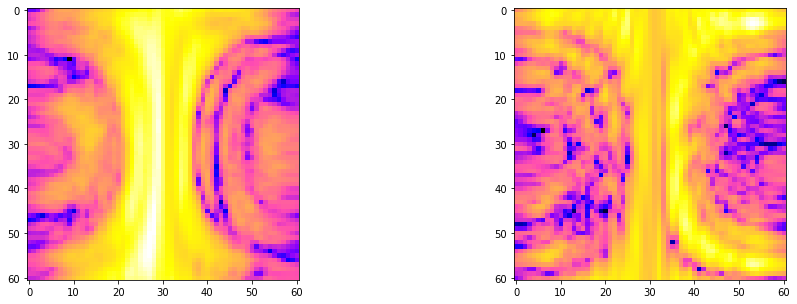

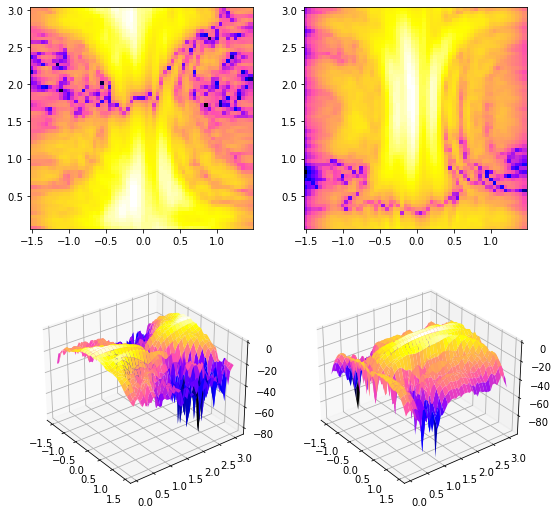

In [198]:
[Etheta,Ephi]=FouriertoFF2(FourierSpace[0],FourierSpace[1],FourierSpace[2],theta,phi,k_X_Rectangular,k_Y_Rectangular,k0,FFOutputs=True)

In [102]:
xx=np.linspace(np.nanmin(k0*np.sin(theta)*np.sin(phi)),np.nanmax(k0*np.sin(theta)*np.sin(phi)),100)
yy=np.linspace(np.nanmin(k0*np.sin(theta)*np.cos(phi)),np.nanmax(k0*np.sin(theta)*np.cos(phi)),100)

In [103]:
# from scipy.interpolate import SmoothBivariateSpline
# [k_X_Rectangular_Grid,k_Y_Rectangular_Grid]=np.meshgrid(k_X_Rectangular,k_Y_Rectangular)

In [104]:
f_x_interp = interp2d(k_X_Rectangular,k_Y_Rectangular,np.abs(FourierSpace[0].T.conj()),kind='linear')
f_y_interp = interp2d(k_X_Rectangular,k_Y_Rectangular,np.abs(FourierSpace[1].T.conj()),kind='linear')
f_z_interp = interp2d(k_X_Rectangular,k_Y_Rectangular,np.abs(FourierSpace[2].T.conj()),kind='linear')

# f_x_interp_real - interp2d(k_X_Rectangular,k_Y_Rectangular,Fourier)

f_x_offset_interp = interp2d(k_X_Rectangular_Offset,k_Y_Rectangular_Offset,np.abs(FourierSpace_offset[0].T.conj()),kind='linear')
f_y_offset_interp = interp2d(k_X_Rectangular_Offset,k_Y_Rectangular_Offset,np.abs(FourierSpace_offset[1].T.conj()),kind='linear')
f_z_offset_interp = interp2d(k_X_Rectangular_Offset,k_Y_Rectangular_Offset,np.abs(FourierSpace_offset[2].T.conj()),kind='linear')

from scipy.interpolate import SmoothBivariateSpline
f_X_Spherical=f_x_interp(xx,yy)
f_Y_Spherical=f_y_interp(xx,yy)
f_Z_Spherical=f_z_interp(xx,yy)

f_X_Spherical_offset=f_x_offset_interp(xx,yy)
f_Y_Spherical_offset=f_y_offset_interp(xx,yy)
f_Z_Spherical_Offset=f_z_offset_interp(xx,yy)

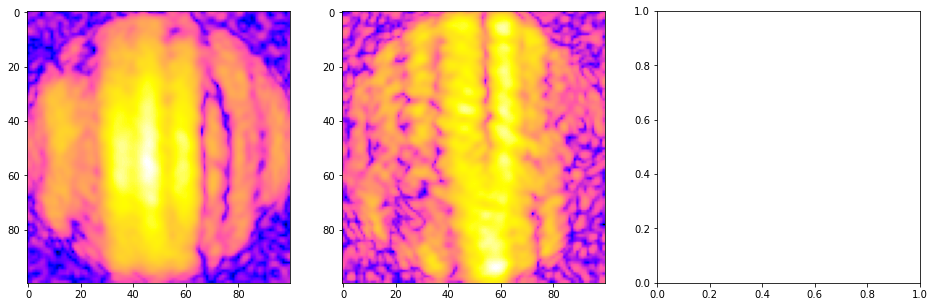

In [105]:
fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
ax1.imshow((np.abs(f_X_Spherical)),aspect='auto',norm=LogNorm(),cmap='gnuplot2')
ax2.imshow((np.abs(f_Y_Spherical)),aspect='auto',norm=LogNorm(),cmap='gnuplot2')
#ax3.imshow((np.abs(f_Z_Spherical)),aspect='auto',norm=LogNorm(),cmap='gnuplot2')

In [106]:
r=10000;
C=1.0j*(k0*np.exp(-1.0j*k0*r))/(2*np.pi*r)
Etheta=C*(f_X_Spherical*np.cos(phi)+f_Y_Spherical*np.sin(phi));
Ephi=C*np.cos(theta)*(-f_X_Spherical*np.sin(phi)+f_Y_Spherical*np.cos(phi));

Etheta_Offset=C*(f_X_Spherical_offset*np.cos(phi)+f_Y_Spherical_offset*np.sin(phi));
Ephi_Offset=C*np.cos(theta)*(-f_X_Spherical_offset*np.sin(phi)+f_Y_Spherical_offset*np.cos(phi)); 

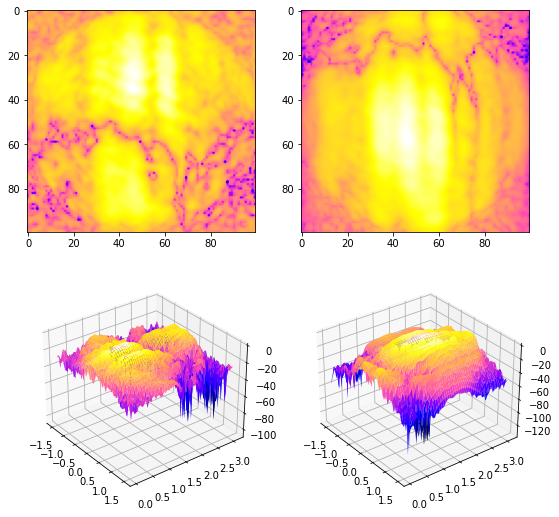

In [107]:
fig=figure(figsize=(9,9))
ax=fig.add_subplot(2,2,1)
ax.imshow(np.log10(np.abs(Etheta)),aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(2,2,2)
ax.imshow(np.log10(np.abs(Ephi)),aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(2,2,3,projection='3d')
ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Etheta))-np.nanmax(20.0*np.log10(np.abs(Etheta.T.conj()))),cmap='gnuplot2')
ax.view_init(30,-37.5)
ax=fig.add_subplot(2,2,4,projection='3d')
ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Ephi))-np.nanmax(20.0*np.log10(np.abs(Ephi.T.conj()))),cmap='gnuplot2')
ax.view_init(30,-37.5)

NameError: name 'Etheta_offset' is not defined

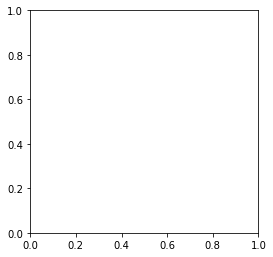

In [108]:
fig=figure(figsize=(9,9))
ax=fig.add_subplot(2,2,1)
ax.imshow(np.log10(np.abs(Etheta_offset)),aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(2,2,2)
ax.imshow(np.log10(np.abs(Ephi_offset)),aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(2,2,3,projection='3d')
ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Etheta_offset))-np.nanmax(20.0*np.log10(np.abs(Etheta.T.conj()))),cmap='gnuplot2')
ax.view_init(30,-37.5)
ax=fig.add_subplot(2,2,4,projection='3d')
ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Ephi_offset))-np.nanmax(20.0*np.log10(np.abs(Ephi.T.conj()))),cmap='gnuplot2')
ax.view_init(30,-37.5)

In [109]:
[Etheta,Ephi] = FouriertoFF(FourierSpace,theta,phi,k_X_Rectangular,k_Y_Rectangular,k0,FFOutputs=True)
[Etheta_offset,Ephi_offset] = FouriertoFF(FourierSpace_offset,theta,phi,k_X_Rectangular_Offset,k_Y_Rectangular_Offset,k0,FFOutputs=True)

ValueError: Method '[[-115.07945312 -114.84824508 -114.50863889 ...  114.50863889
   114.84824508  115.07945312]
 [-185.66717851 -185.2941515  -184.7462368  ...  184.7462368
   185.2941515   185.66717851]
 [-256.07966412 -255.56517023 -254.80946416 ...  254.80946416
   255.56517023  256.07966412]
 ...
 [-256.07966412 -255.56517023 -254.80946416 ...  254.80946416
   255.56517023  256.07966412]
 [-185.66717851 -185.2941515  -184.7462368  ...  184.7462368
   185.2941515   185.66717851]
 [-115.07945312 -114.84824508 -114.50863889 ...  114.50863889
   114.84824508  115.07945312]]' is not defined

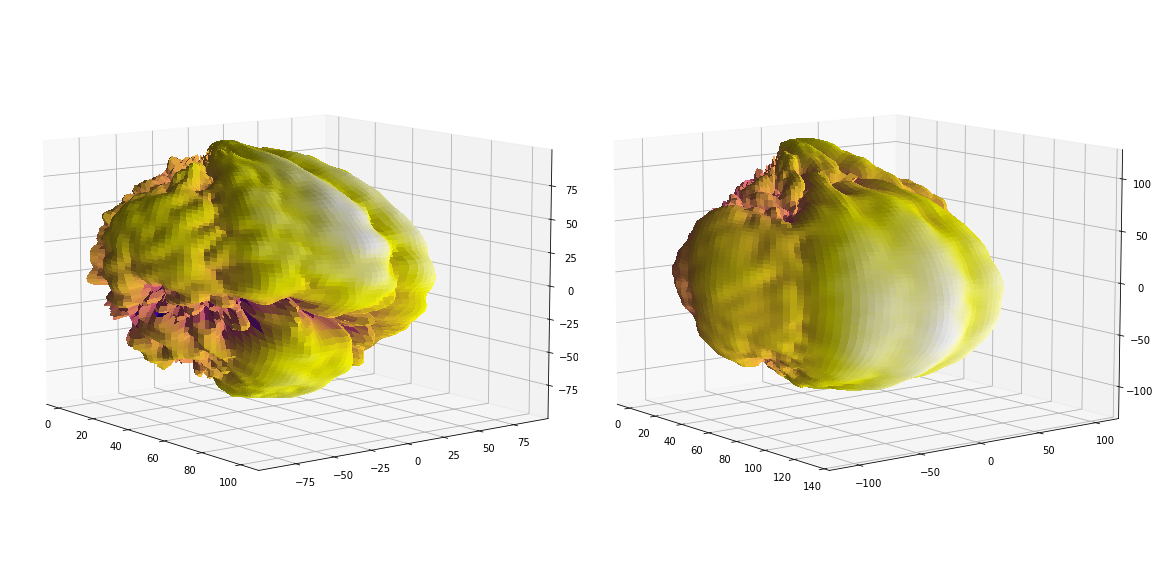

In [45]:
fig=figure(figsize=(16,10))
ax=fig.add_subplot(1,2,1,projection='3d')
R=20.0*np.log10(np.abs(Etheta))-np.nanmin(20.0*np.log10(np.abs(Etheta.T.conj())))
X=R*np.cos(theta)*np.sin(phi)
Y=R*np.sin(theta)*np.sin(phi)
Z=R*np.cos(phi)
dist = np.sqrt(X**2 + Y**2 + Z**2)
dist_max = np.max(dist)
my_col = cm.gnuplot2(dist/dist_max)
ax.plot_surface(X,Y,Z,rstride=1, cstride=1, facecolors=my_col, linewidth=0, antialiased=False)
ax.view_init(10,-37.5)


ax=fig.add_subplot(1,2,2,projection='3d')
R=20.0*np.log10(np.abs(Ephi))-np.nanmin(20.0*np.log10(np.abs(Ephi.T.conj())))
X=R*np.cos(theta)*np.sin(phi)
Y=R*np.sin(theta)*np.sin(phi)
Z=R*np.cos(phi)
dist = np.sqrt(X**2 + Y**2 + Z**2)
dist_max = np.max(dist)
my_col = cm.gnuplot2(dist/dist_max)
ax.plot_surface(X,Y,Z,rstride=1, cstride=1, facecolors=my_col, linewidth=0, antialiased=False)
ax.view_init(10,-37.5)
tight_layout()


In [ ]:
Etheta_errors = electric_field_errors(Etheta,Etheta_offset,theta,phi,'theta','phi',outputs=1)
Ephi_errors = electric_field_errors(Ephi,Ephi_offset,theta,phi,'theta','phi',outputs=1)

In [ ]:
def rot_mat(ypr_arr):
    [a,b,c]=(np.pi/180.0)*ypr_arr
    RM=np.ndarray((3,3))
    RM[0,:]=[np.cos(a)*np.cos(b),np.cos(a)*np.sin(b)*np.sin(c)-np.sin(a)*np.cos(c),np.cos(a)*np.sin(b)*np.cos(c)+np.sin(a)*np.sin(c)]
    RM[1,:]=[np.sin(a)*np.cos(b),np.sin(a)*np.sin(b)*np.sin(c)+np.cos(a)*np.cos(c),np.sin(a)*np.sin(b)*np.cos(c)-np.cos(a)*np.sin(c)]
    RM[2,:]=[-1*np.sin(b),np.cos(b)*np.sin(c),np.cos(b)*np.cos(c)]
    return RM

def xyz_to_rpt(xyz):
    r_prime=np.sqrt((xyz[0]**2.0)+(xyz[1]**2.0)+(xyz[2]**2.0))
    phi_prime=np.arctan2(xyz[1],xyz[0])
    if phi_prime<0:
        phi_prime=phi_prime+(2.0*np.pi)
    theta_prime=np.arccos(xyz[2]/r_prime)
    rpt=[r_prime,phi_prime,theta_prime]
    return rpt

In [ ]:
rot_r=np.zeros((100,100))
rot_phi=np.zeros((100,100))
rot_theta=np.zeros((100,100))
for i in range(100):
    for j in range(100):
        if i==23 and j==3:
            rot_r[i,j]=np.nan
            rot_phi[i,j]=rot_phi[i-1,j-1]
            rot_theta[i,j]=rot_theta[i-1,j-1]
        else:
            rot_r[i,j]=xyz_to_rpt(np.dot(rot_mat(np.array([-90,-90,-180])),np.array([X[i,j],Y[i,j],Z[i,j]])))[0]
            rot_phi[i,j]=xyz_to_rpt(np.dot(rot_mat(np.array([-90,-90,-180])),np.array([X[i,j],Y[i,j],Z[i,j]])))[1]
            rot_theta[i,j]=xyz_to_rpt(np.dot(rot_mat(np.array([-90,-90,-180])),np.array([X[i,j],Y[i,j],Z[i,j]])))[2]


In [ ]:
fig=figure(figsize=(16,16))
fig.set_facecolor('k')
ax1=fig.add_subplot(3,3,5,projection='polar')
ax1.scatter(rot_phi,rot_theta,c=rot_r,cmap='gnuplot2',s=20)


ax2=fig.add_subplot(3,3,2)
ax2.pcolormesh(-Y[50:,:],X[50:,:],R[50:,:],cmap='gnuplot2',norm=LogNorm())
ax3=fig.add_subplot(3,3,4)
ax3.pcolormesh(-X[:,50:],-Z[:,50:],R[:,50:],cmap='gnuplot2',norm=LogNorm())
ax4=fig.add_subplot(3,3,6)
ax4.pcolormesh(X[:,:50],-Z[:,:50],R[:,:50],cmap='gnuplot2',norm=LogNorm())
ax5=fig.add_subplot(3,3,8)
ax5.pcolormesh(-Y[:50:-1,:],-X[:50:-1,:],R[:50:-1,:],cmap='gnuplot2',norm=LogNorm())


for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_facecolor('k')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
tight_layout()
